In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

%matplotlib inline

In [2]:
mpl.rcParams['text.usetex'] = False
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['legend.fontsize'] = 12
#mpl.rcParams['font.sans-serif'] = 'IBM Plex Sans Condensed'

In [3]:
files = glob("../data/ChokepointPotential/201*/*.txt")

In [4]:
month_map = {"Jan":1,
             "Feb":2,
             "Mar":3,
             "Apr":4,
             "May":5,
             "Jun":6,
             "Jul":7,
             "Aug":8,
             "Sep":9,
             "Oct":10,
             "Nov":11,
             "Dec":12}

In [5]:
def year_month(fname):
    l = fname.split("/")
    year = int(l[-2][0:4])
    month = l[-2][4:7]
    return year, month_map[month]

In [6]:
def get_type(fname):
    l = fname.split("/")
    return l[-1].split(".")[-2].split("_")[-1]

In [7]:
def get_df(fname):
    df = pd.read_csv(fname,sep="|",header=None,names=["ASN","CC","Chokepoint"])
    year,month = year_month(fname)
    df['year'] = year
    df['month'] = month
    df['date'] = year + (month-1)/12.0
    df['type'] = get_type(fname)
    df['log_chokepoint'] = np.log10(df['Chokepoint'])
    return df

In [8]:
import joypy as jp

In [9]:
df = pd.concat(map(get_df,files))

/Users/BenjaminEdwards/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


In [10]:
def get_numASNs(CC, thresh, type='ito'):
    ds = sorted(df.date.unique())
    filt = (df.CC==CC) & (df.type=='ito')
    data = []
    for d in ds:
        filt = (df.CC==CC) & (df.type=='ito') & (df.date==d)
        df_filt = df[filt].sort_values("Chokepoint",ascending=False)
        df_filt['Cum_Chokepoint'] = df_filt.Chokepoint.cumsum()
        idxs = np.where(df_filt.Cum_Chokepoint < thresh)[0]
        if idxs.shape[0]==0:
            data.append(1)
        else:
            data.append(idxs.max()+1)
    return data

In [11]:
CC_map = {'CN': "China",
          'US': 'United States',
          'GB': "Great Britain",
          'DE': "Germany",
          "IR": "Iran",
          "AU": "Australia",
          "BR": "Brazil",
          "RU": "Russia",
          "FR": "France"}

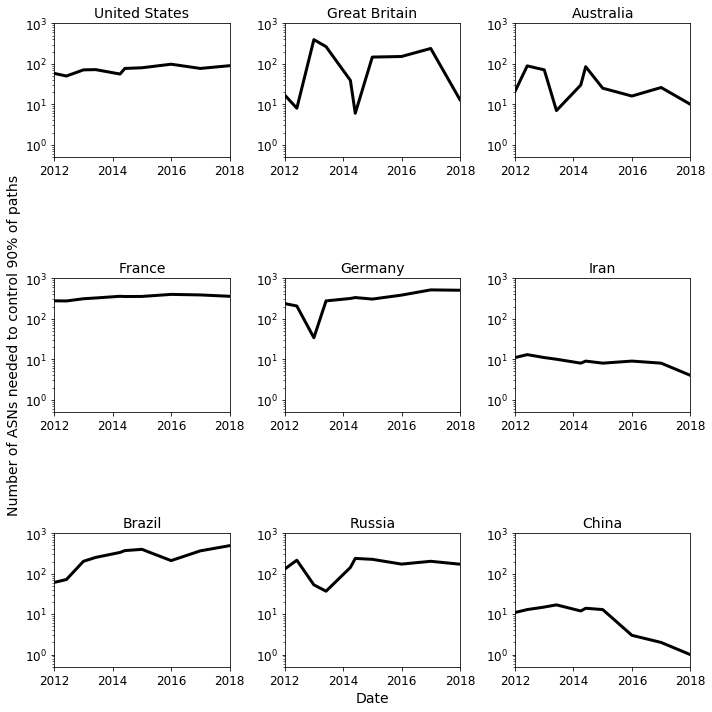

In [13]:
plt.figure(figsize=(10,10))
i = 1
thresh = 0.9
ds = sorted(df.date.unique())
for CC in ['US','GB','AU','FR','DE','IR','BR','RU','CN']:
    plt.subplot(3,3,i)
    data = get_numASNs(CC,thresh=thresh)
    #plt.fill_between(ds,data[0.25],data[0.9],color='k',alpha=0.2)
    plt.plot(ds,data,color='k',lw=3)
    plt.yscale('log')
    plt.xlim(min(ds),max(ds))
    plt.ylim(0.5,1e3)
    plt.title(CC_map[CC])
    if i==4:
        plt.ylabel("Number of ASNs needed to control %2.0f%% of paths"%(100*thresh))
    if i==8:
        plt.xlabel("Date")
    i+=1
plt.tight_layout()

In [14]:
def get_totalControl(CC, num_ASNs, type='ito'):
    ds = sorted(df.date.unique())
    filt = (df.CC==CC) & (df.type=='ito')
    data = []
    for d in ds:
        filt = (df.CC==CC) & (df.type=='ito') & (df.date==d)
        df_filt = df[filt].sort_values("Chokepoint",ascending=False)
        df_filt['Cum_Chokepoint'] = df_filt.Chokepoint.cumsum()
        data.append(df_filt.iloc[num_ASNs-1].Chokepoint)
    return data

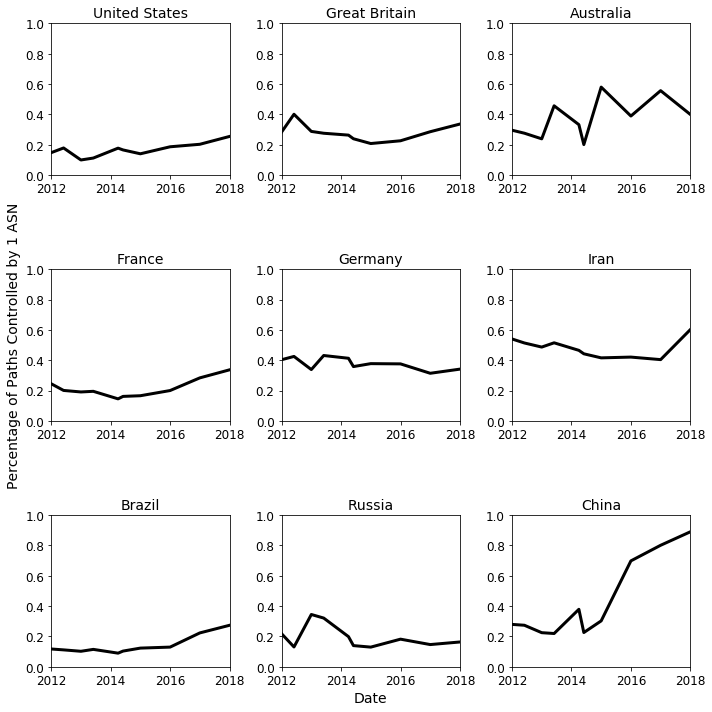

In [16]:
plt.figure(figsize=(10,10))
i = 1
num_ASNs = 1
for CC in ['US','GB','AU','FR','DE','IR','BR','RU','CN']:
    plt.subplot(3,3,i)
    data = get_totalControl(CC,1)
    plt.plot(ds,data,color='k',lw=3)
    plt.xlim(min(ds),max(ds))
    plt.ylim(0.0,1)
    plt.title(CC_map[CC])
    if i==4:
        plt.ylabel("Percentage of Paths Controlled by %d ASN"%(num_ASNs))
    if i==8:
        plt.xlabel("Date")
    i+=1
plt.tight_layout()